In [130]:
import pickle
import numpy as np
from tcn_class import TCN
from torch import nn
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [131]:
WIN_SIZE = 64
STRIDE = 4
PATH = 'shift_less_ab_test'
with open('data/{}/train.pkl'.format(PATH), 'rb') as f:
    train_df = pickle.load(f)

def prep_df(df, in_channels, win_size, stride):
    series_len = len(df[0])
    df_size = ((series_len - win_size) // stride) + 1
    torch_df = torch.FloatTensor(df_size, in_channels, win_size)
    for i in range(df_size):
        sample = df[:, stride*i: stride*i+win_size]
        torch_df[i] = sample
    residual_series = df[:, -win_size:].reshape(1,in_channels, -1)
    # torch_df = torch.clamp(torch_df, 0, 1)
    # residual_series = torch.clamp(residual_series, 0, 1)
    return torch_df, residual_series

in_channels = len(train_df)
train, train_resid = prep_df(train_df, in_channels, WIN_SIZE, STRIDE) 
train_size = train.shape[0]

from tcn_autoencoder import TCN_autoencoder

# model = TCN((in_channels, 24, 16, 24, in_channels), 3)
model = TCN_autoencoder(scale_factor=4, in_channels=in_channels, kernel_size=3, dropout=0) 
# model.load_state_dict(torch.load('saved_models/best_base_model.pt'))
# model.eval()

loss_history = []

In [90]:
1 1
2 2
3 4
4 8
5 16
6 32
7 64

SyntaxError: invalid syntax (Temp/ipykernel_18408/2531024487.py, line 1)

  0%|          | 0/50 [00:00<?, ?it/s]

1.4369916915893555
0.735769510269165
0.544055163860321
0.46758022904396057
0.4336869418621063
0.41976654529571533
0.41468557715415955
0.4126787483692169
0.411702424287796
0.4111359119415283
0.4108220338821411


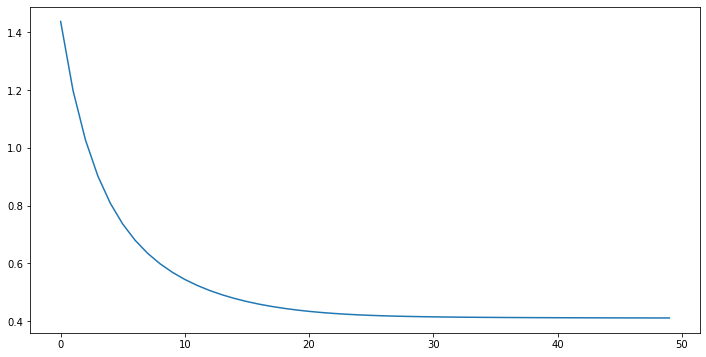

In [132]:
epochs_n = 50
learning_rate = 1e-3
criterion = nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

for ep in tqdm(range(epochs_n)):
    ep_loss = 0
    pred = model(train)
    loss = criterion(pred, train)

    pred_resid = model(train_resid)
    loss_resid = criterion(pred_resid, train_resid)
    loss = (loss*train_size + loss_resid) / (train_size + 1)

    optim.zero_grad()
    loss.backward()
    optim.step()

    loss_history.append(loss.item())

    if ep % 5 == 0:
        print(loss.item()) 

print(loss.item()) 
plt.figure(figsize=(12,6))
plt.plot(loss_history[:]) 

In [146]:
torch.save(model.state_dict(), 'saved_models/sim_anom_64_4.pt')

0.4107554116007785


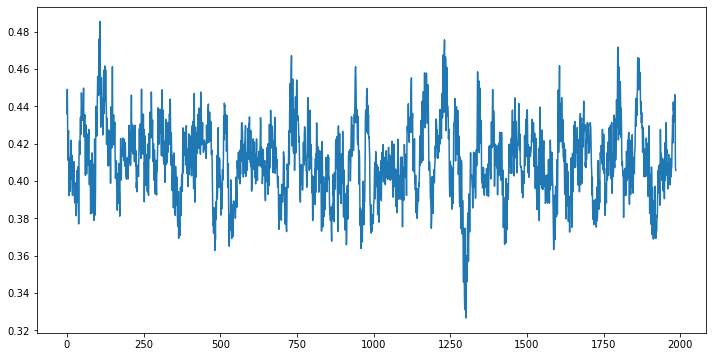

In [134]:
with torch.no_grad():
    train_loss = []
    for sample in train:
        pred = model(sample.reshape(1, in_channels, -1))
        loss = criterion(pred, sample.reshape(1, in_channels, -1))
        train_loss.append(loss.item())

    pred_resid = model(train_resid)
    loss_resid = criterion(pred_resid, train_resid)
    train_loss.append(loss_resid.item())

plt.figure(figsize=(12,6))
plt.plot(train_loss)
print(np.mean(train_loss)) 

0.40933086940781077


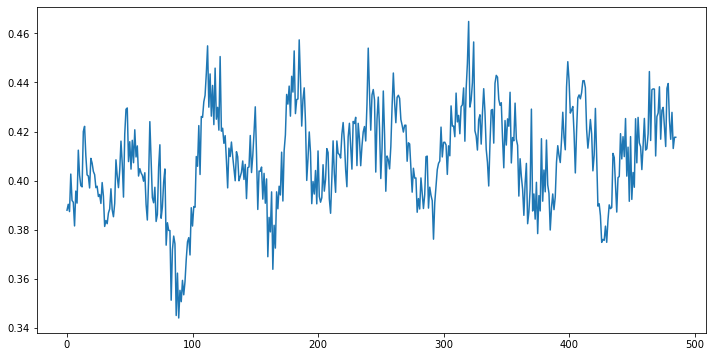

In [135]:
with open('data/{}/valid.pkl'.format(PATH), 'rb') as f:
    valid_np = pickle.load(f)

valid, valid_resid = prep_df(valid_np, in_channels, WIN_SIZE, STRIDE)
valid_size = valid.shape[0]

with torch.no_grad():
    valid_loss = []
    for sample in valid:
        pred = model(sample.reshape(1, in_channels, -1))
        loss = criterion(pred, sample.reshape(1, in_channels, -1))
        valid_loss.append(loss.item())

    pred_resid = model(valid_resid)
    loss_resid = criterion(pred_resid, valid_resid)
    valid_loss.append(loss_resid.item())

plt.figure(figsize=(12,6))
plt.plot(valid_loss)
print(np.mean(valid_loss))
max_valid_er = np.max(valid_loss) 

0.41166200209671344


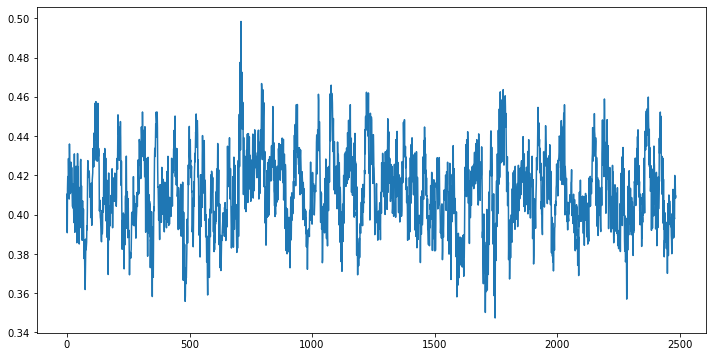

In [136]:
with open('data/{}/test.pkl'.format(PATH), 'rb') as f:
    test_np = pickle.load(f)

test, test_resid = prep_df(test_np, in_channels, WIN_SIZE, STRIDE)
with torch.no_grad():
    test_loss = []
    for sample in test:
        pred = model(sample.reshape(1, in_channels, -1))
        loss = criterion(pred, sample.reshape(1, in_channels, -1))
        test_loss.append(loss.item())
    
    pred_resid = model(test_resid)
    loss_resid = criterion(pred_resid, test_resid)
    test_loss.append(loss_resid.item())

plt.figure(figsize=(12,6))
plt.plot(test_loss)
print(np.mean(test_loss)) 

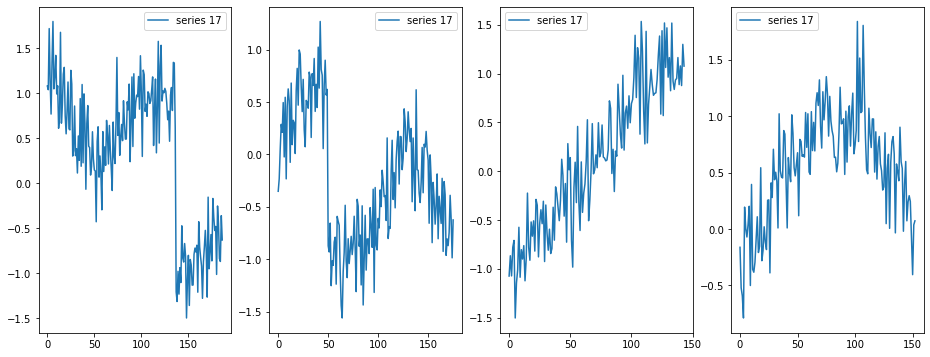

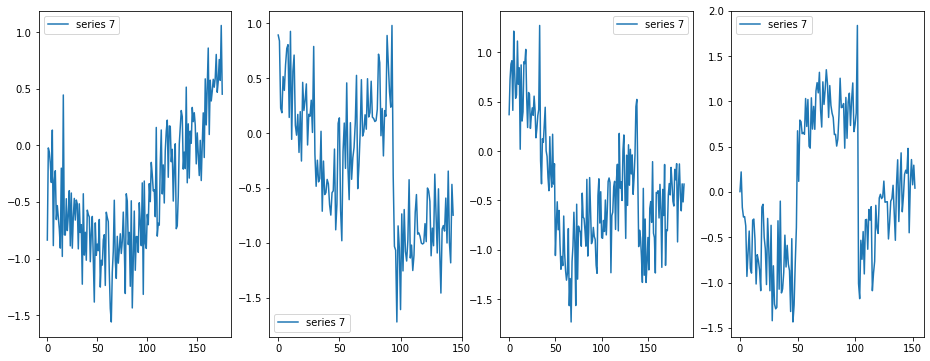

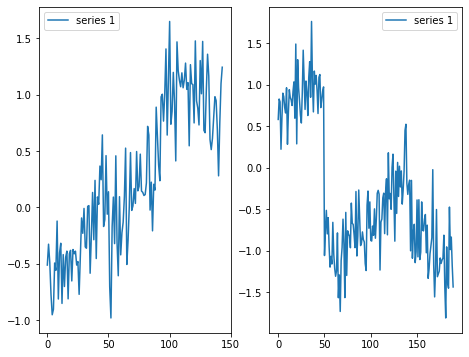

In [137]:
with open('data/{}/errors_positions.pkl'.format(PATH), 'rb') as f:
    er_pos = pickle.load(f)

for i in range(3):
    fig = plt.figure(figsize=(20,6))
    counter = 0
    ser = er_pos.keys()
    ser = list(ser)[i]

    for er_start, er_end in er_pos[ser]:
        ax = fig.add_subplot(151+counter)
        counter+=1
        ax.plot(test_np[ser, er_start-50:er_end+50],  label='series {}'.format(ser+1))
        plt.legend() 

In [138]:
er_pos

{16: [[3146, 3233], [4734, 4810], [7161, 7205], [8862, 8915]],
 6: [[4734, 4810], [7161, 7205], [8068, 8158], [8742, 8795]],
 0: [[7161, 7205], [8128, 8218]]}

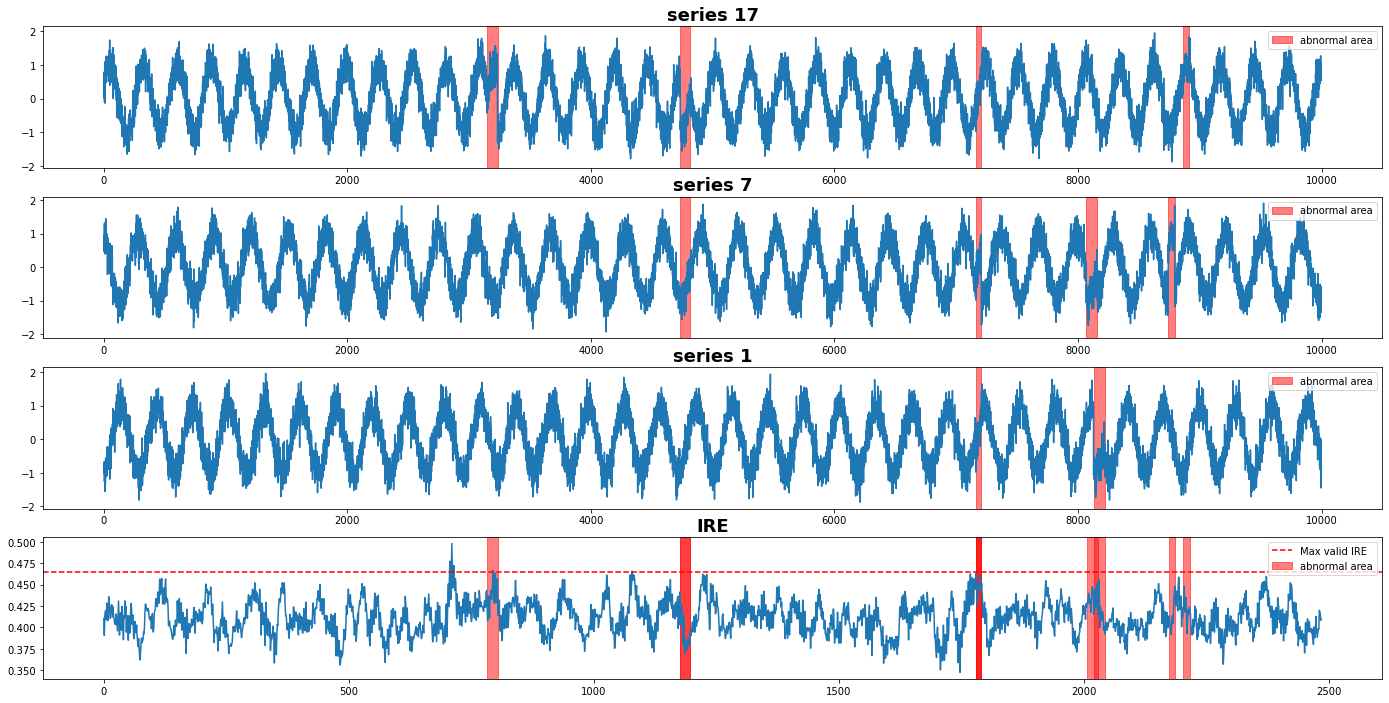

In [139]:
test_size = (test_np.shape[1] - WIN_SIZE)//STRIDE
resid_part = test_np.shape[1] - (test_size*STRIDE) - WIN_SIZE

fig = plt.figure(figsize=(24,12))

# test_np_ct = test_np[:, :99*STRIDE+WIN_SIZE]
test_np_ct = test_np
test_sec_size = test_np_ct.shape[1]
test_loss_size = len(test_loss)
sec_loss_scale = test_sec_size/test_loss_size

ax4 = fig.add_subplot(414)
ax4.plot(test_loss)
ax4.set_title('IRE', weight='bold',  size=18)

params = {  'color':'red',
            'alpha':0.5 }

for i, ser in enumerate(er_pos):
    ax = fig.add_subplot(411+i)
    ax.plot(test_np_ct[ser])
    ax.set_title('series {}'.format(ser+1), weight='bold', size=18)

    is_first = True
    for er_start, er_end in er_pos[ser]:
        if i == 0 and is_first:
            ax4.axvspan(er_start/sec_loss_scale, er_end/sec_loss_scale, label='abnormal area', **params)
        else:
            ax4.axvspan(er_start/sec_loss_scale, er_end/sec_loss_scale, **params)
    
        if is_first:
            ax.axvspan(er_start, er_end, label='abnormal area', **params)
            is_first=False
        else: 
            ax.axvspan(er_start, er_end, **params)

    ax.legend(loc='upper right')


anomaly_border = max_valid_er 
ax4.axhline(anomaly_border, color='r', linestyle='--', label='Max valid IRE') 

ax4.legend(loc='upper right')

In [140]:
test, test_resid = prep_df(test_np, in_channels, WIN_SIZE, STRIDE)
b = 0
with torch.no_grad():
    test_losses = []
    for sample in test:
        pred = model(sample.reshape(1, in_channels, -1))
        chan_loss = []
        for test_it, pred_it in zip(sample, pred[0]):
            loss = criterion(pred_it, test_it)
            chan_loss.append(loss.item())  
        test_losses.append(chan_loss)

    pred = model(test_resid)
    chan_loss = []
    for test_it, pred_it in zip(test_resid[0], pred[0]):
        loss = criterion(pred_it, test_it)
        chan_loss.append(loss.item())  
    test_losses.append(chan_loss)

# plt.figure(figsize=(12,6))
# plt.plot(test_loss)
# print(np.mean(test_loss))

In [141]:
test_resid.shape

torch.Size([1, 30, 64])

In [142]:
test_losses = np.asarray(test_losses)

In [143]:
test_losses.shape

(2485, 30)

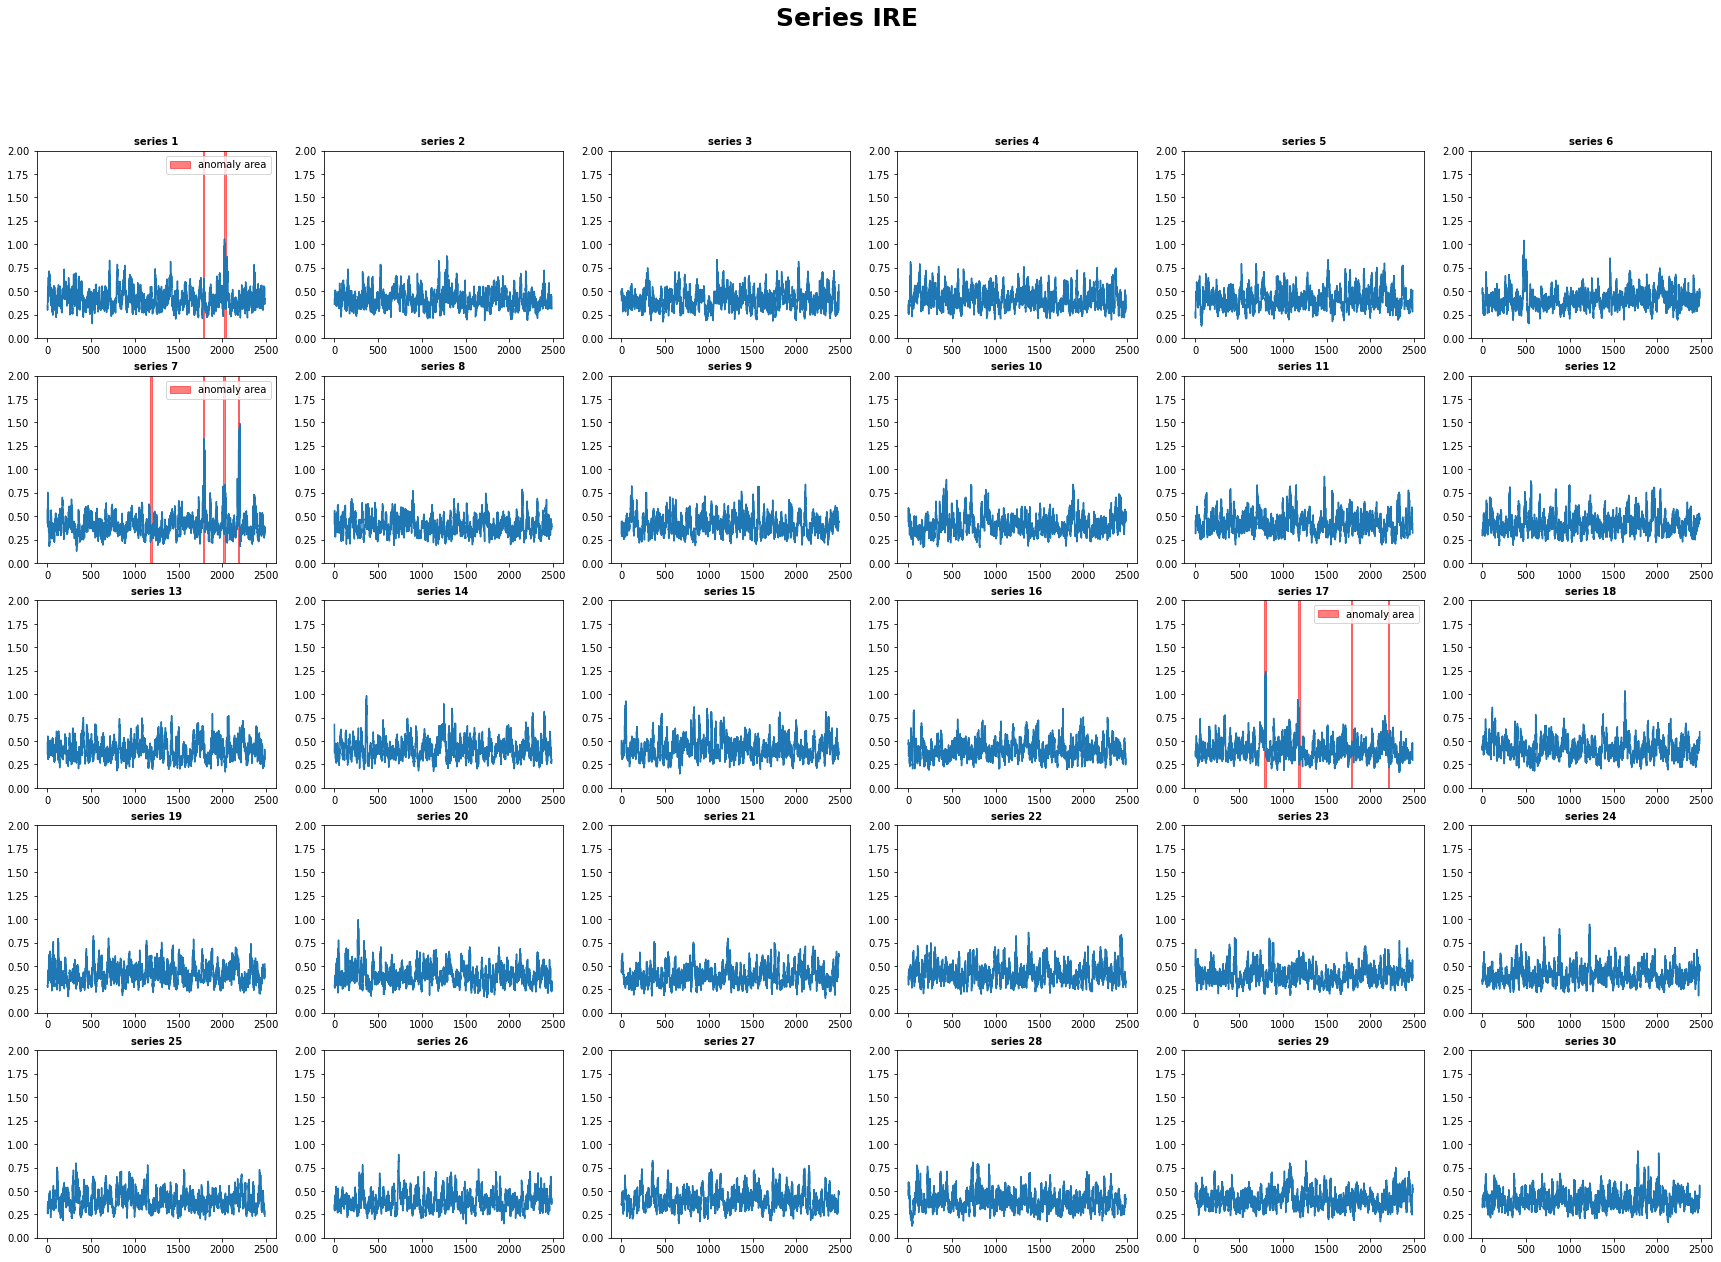

In [144]:
cols = 6
rows = 5
counter = 0 
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(30, 20))
fig.suptitle('Series IRE', weight='bold', size=25)
for row in range(rows):
    for col in range(cols):
        ax[row,col].plot(test_losses[:, counter])
        ax[row,col].set_title('series {}'.format(counter+1), weight='bold', size=10)
        ax[row,col].set_ylim([0, 2])
        if counter in er_pos:
            is_first = True
            for er_start, er_end in er_pos[counter]:
                if is_first:
                    ax[row,col].axvspan(er_start/sec_loss_scale, er_end/sec_loss_scale, label='anomaly area', **params)
                    is_first=False
                else: 
                    ax[row,col].axvspan(er_start/sec_loss_scale, er_end/sec_loss_scale, **params)

            ax[row,col].legend(loc='upper right')
            
        counter+=1

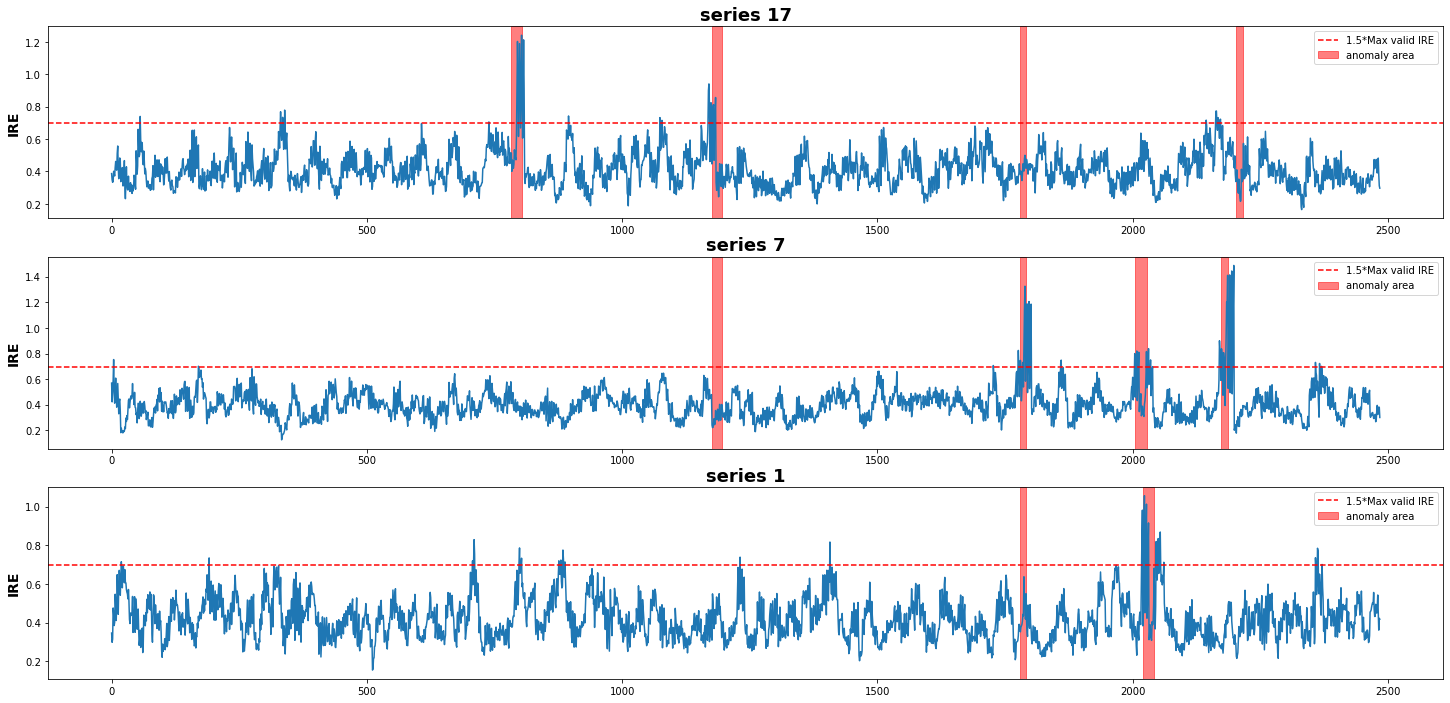

In [145]:
anomaly_border = 1.5*max_valid_er 

fig = plt.figure(figsize=(25,12))
for i, ser in enumerate(er_pos):
    ax = fig.add_subplot(311+i)

    ax.plot(test_losses[:, ser])
    ax.set_title('series {}'.format(ser+1), weight='bold', size=18)
    ax.axhline(anomaly_border, color='r', linestyle='--', label='1.5*Max valid IRE') 
    
    is_first = True
    for er_start, er_end in er_pos[ser]:
        ax.set_ylabel('IRE',  weight='bold', size=14)
        if is_first:
            ax.axvspan(er_start/sec_loss_scale, er_end/sec_loss_scale, label='anomaly area', **params)
            is_first=False
        else: 
            ax.axvspan(er_start/sec_loss_scale, er_end/sec_loss_scale, **params)
        

    ax.legend(loc='upper right')

In [129]:
er_pos

{16: [[3146, 3233], [4734, 4810], [7161, 7205], [8862, 8915]],
 6: [[4734, 4810], [7161, 7205], [8068, 8158], [8742, 8795]],
 0: [[7161, 7205], [8128, 8218]]}

In [114]:
test_losses.shape

(2485, 30)